In [27]:
%matplotlib inline

import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from hep2_classification.segmentation import SegmentationResult
from hep2_classification.presentation import display_grid, ImagePlotter

In [87]:
%%time

data_dir = '../data/segmented/'

class_dict = {
    'aca': 0,
    'ama': 1,
    'zia': 2,
    'nuc': 3,
    'hom': 4,
    'fib': 5,
    'dot': 6
    
}

files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'NEG' not in f]

files_classes = []
for f in files:
    for k in class_dict.keys():
        if k.upper() in f:
            files_classes.append(class_dict[k])

results = [SegmentationResult.load(f) for f in files]
cells = []
classes = []

for c, r in zip(files_classes, results):
    new_cells = list(r.cells)
    cells = cells + new_cells
    classes = classes + len(new_cells) * [c]

CPU times: user 3.02 s, sys: 73.1 ms, total: 3.09 s
Wall time: 3.11 s


In [88]:
print(len(cells), len(classes))

6000 6000


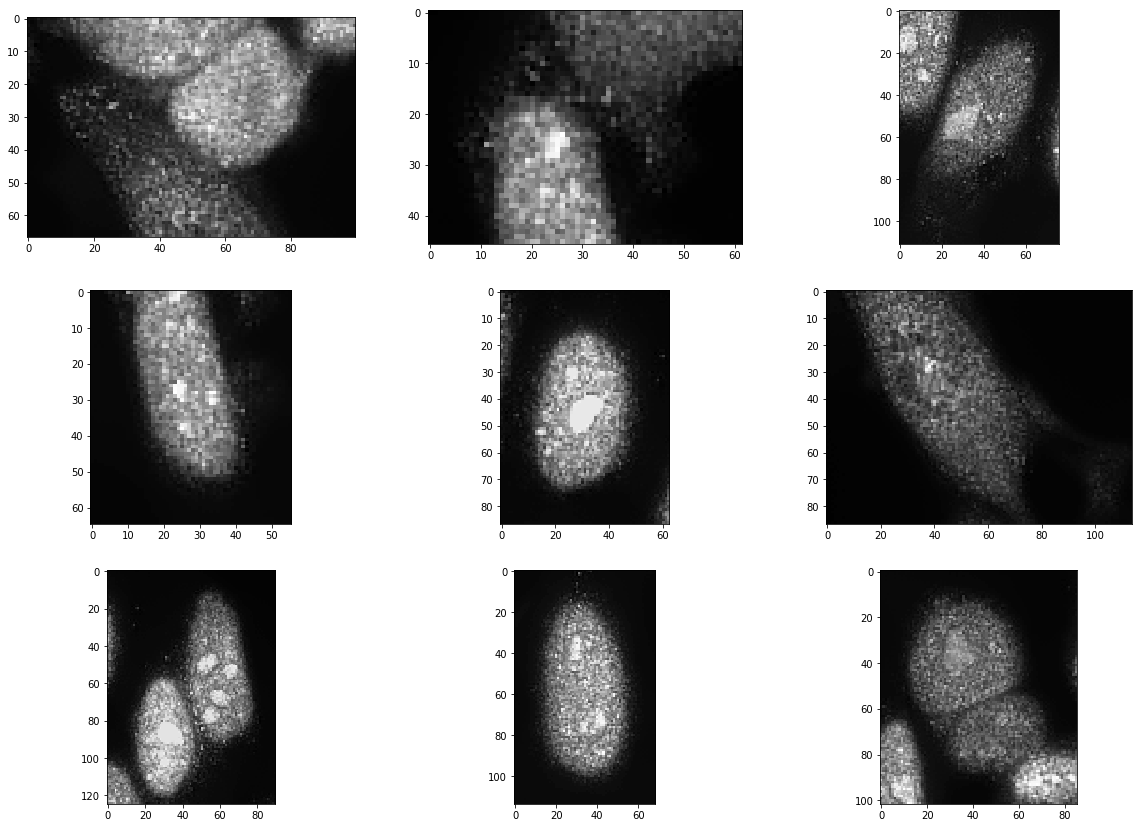

In [69]:
display_grid(cells[:9], ImagePlotter())

## normalizing images

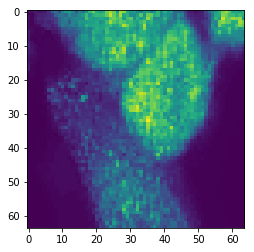

In [74]:
def prepare(img, target_size):
    return cv2.resize(img, target_size) / 255

plt.imshow(prepare(cells[0], target_size=(64, 64)))

CPU times: user 543 ms, sys: 39.9 ms, total: 583 ms
Wall time: 582 ms


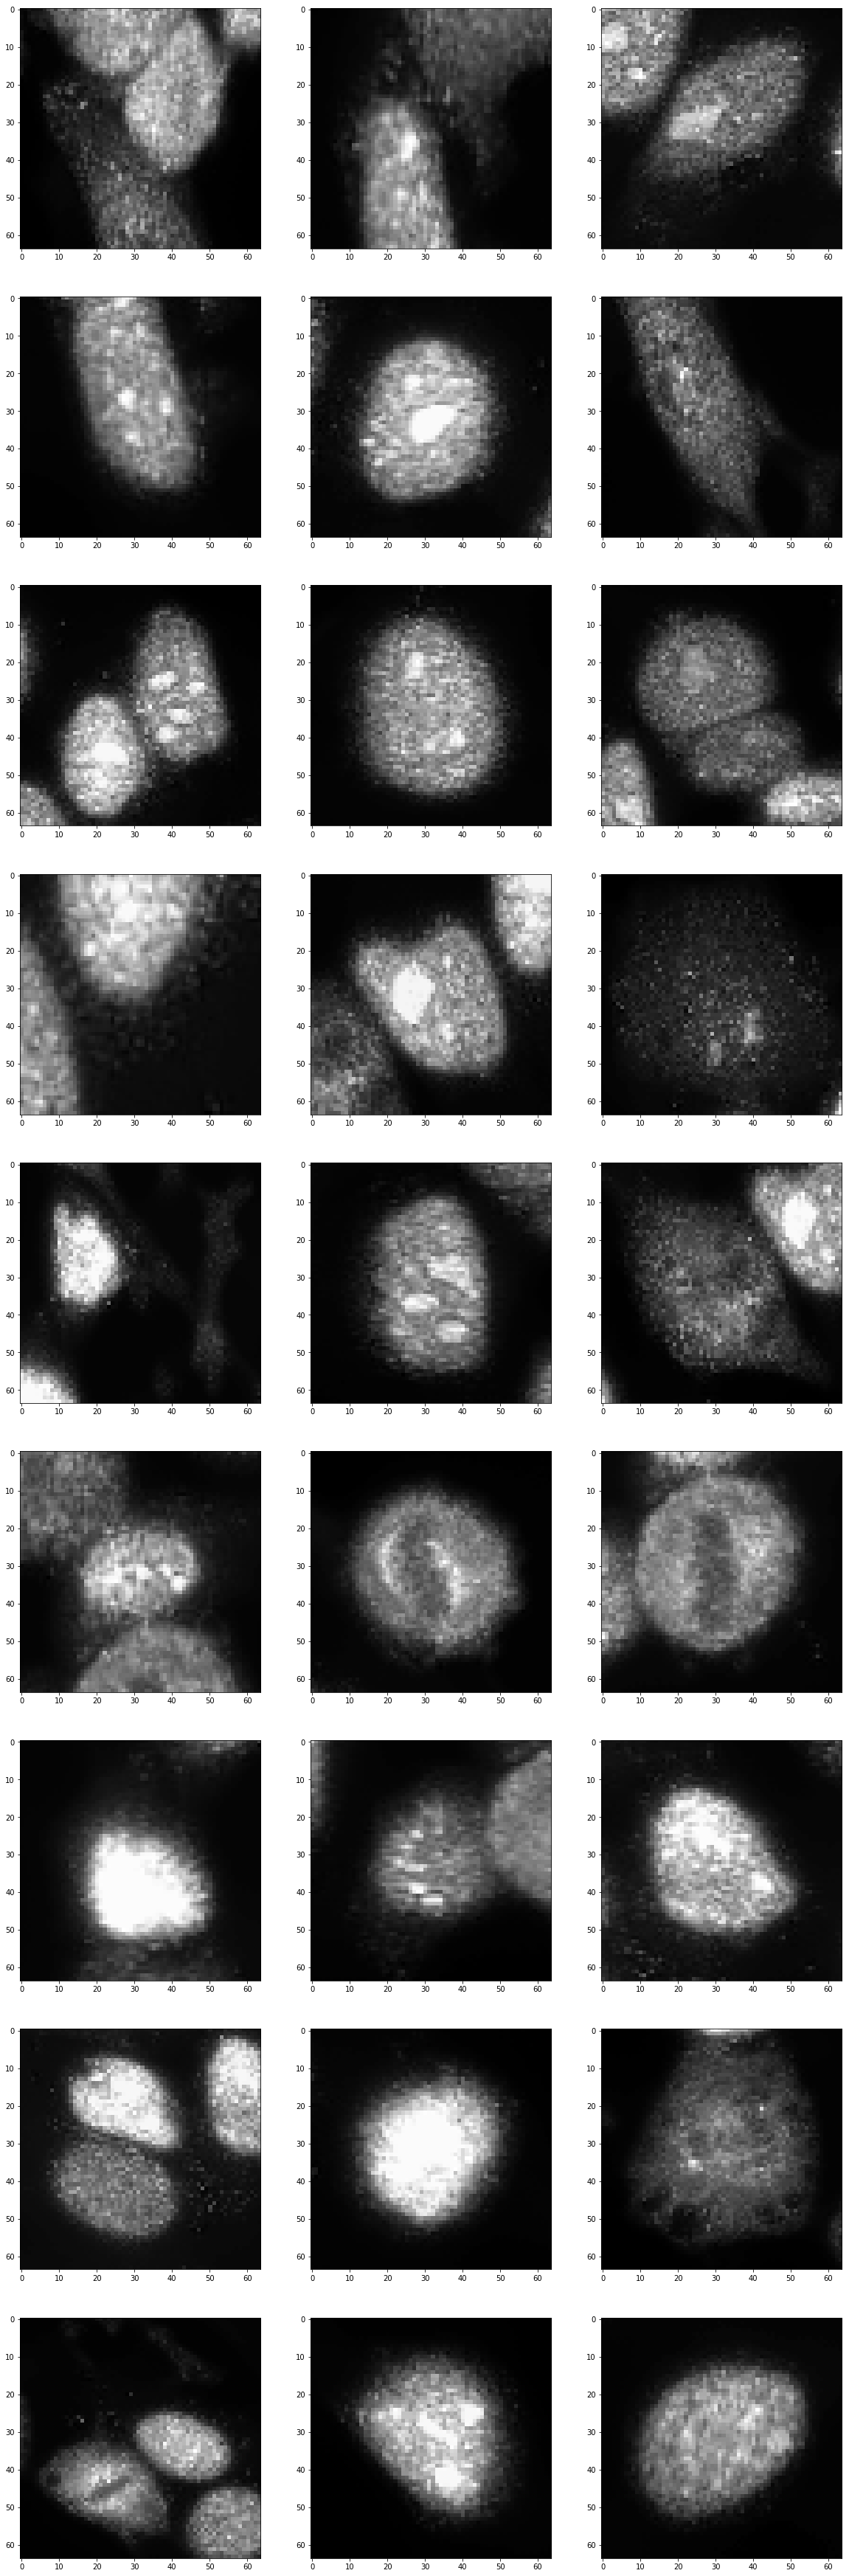

In [107]:
%%time

size = (64, 64)

cells_scaled = [prepare(i, target_size=size) for i in cells]
display_grid(cells_scaled[:27], ImagePlotter())

## preparing dataset

In [109]:
X = np.array(cells_scaled)
X = np.expand_dims(X, axis=3)
print(X.shape)

y = np.array(classes)
print(y.shape)

for k, v in class_dict.items():
    print(f'{k}: {len(y[y == v])}')

(6000, 64, 64, 1)
(6000,)
aca: 1664
ama: 396
zia: 1532
nuc: 659
hom: 862
fib: 331
dot: 556


In [111]:
filtered_classes = ['aca', 'zia']
classes_numbers = [class_dict[k] for k in filtered_classes]

filter_indices = np.array([c in classes_numbers for c in classes])

X_filtered = X[filter_indices]
y_filtered = y[filter_indices]
dataset = X_filtered, y_filtered

## building model

In [112]:
model_input = keras.Input(shape=(size[0], size[1], 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(model_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Flatten()(x)
x = layers.Dense(200)(x)
x = layers.Dense(800)(x)
model_output = layers.Dense(7, activation='softmax')(x)

model = keras.Model(model_input, model_output, name='cells-classifier')
model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 62, 62, 16)        160       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 18, 18, 32)        9248      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 16)     

In [113]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [116]:
X, y = dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 64, 64, 1), (2237,), (959, 64, 64, 1), (959,))

In [117]:
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=256,
    shuffle=True,
    validation_data=(X_test, y_test)
)

Train on 2237 samples, validate on 959 samples
Epoch 1/30
2237/2237 [==============================] - 2s 1ms/sample - loss: 1.0102 - val_loss: 0.5814
Epoch 2/30
2237/2237 [==============================] - 1s 664us/sample - loss: 0.6394 - val_loss: 0.4893
Epoch 3/30
2237/2237 [==============================] - 1s 670us/sample - loss: 0.4620 - val_loss: 0.3203
Epoch 4/30
2237/2237 [==============================] - 2s 683us/sample - loss: 0.3135 - val_loss: 0.3488
Epoch 5/30
2237/2237 [==============================] - 2s 675us/sample - loss: 0.3162 - val_loss: 0.2416
Epoch 6/30
2237/2237 [==============================] - 2s 675us/sample - loss: 0.2491 - val_loss: 0.2227
Epoch 7/30
2237/2237 [==============================] - 2s 692us/sample - loss: 0.2247 - val_loss: 0.1973
Epoch 8/30
2237/2237 [==============================] - 1s 665us/sample - loss: 0.1939 - val_loss: 0.1892
Epoch 9/30
2237/2237 [==============================] - 1s 669us/sample - loss: 0.1763 - val_loss: 0.1763
E

In [131]:
test_preds = model.predict(X_test)
print('predicted:\t', np.argmax(test_preds, axis=1)[9:18])
print('true:\t\t', y_test[9:18])

predicted:	 [2 2 2 0 0 2 0 2 0]
true:		 [2 2 2 0 0 2 0 2 0]


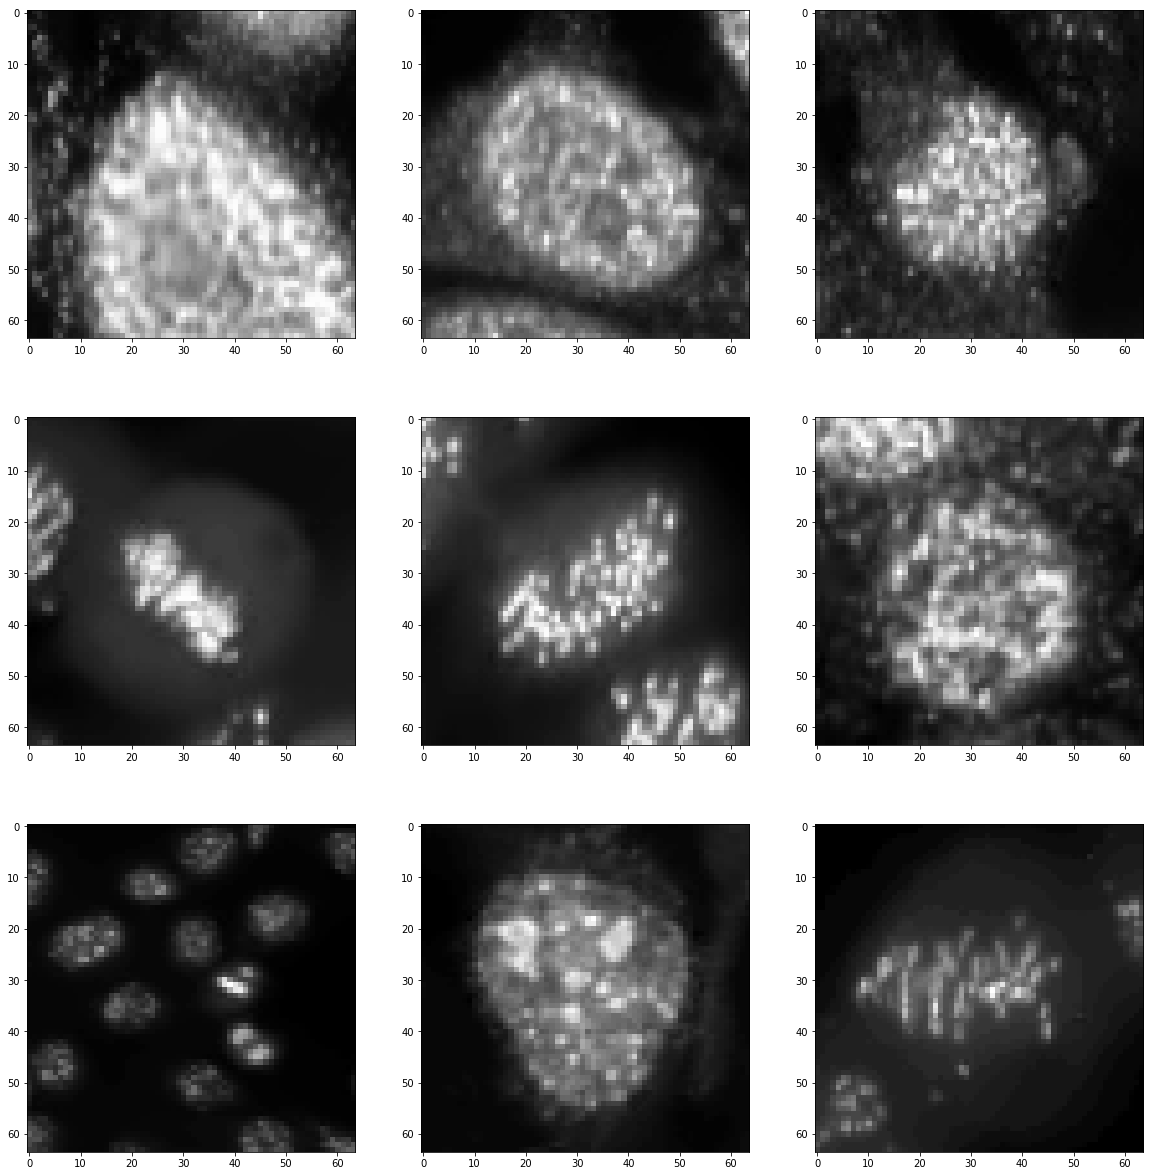

In [121]:
display_grid(np.squeeze(X_test[9:18], axis=3), ImagePlotter())

In [132]:
validation = (np.argmax(test_preds, axis=1) == y_test)

In [133]:
np.mean(validation)

0.9718456725755996